In [1]:
## https://www.physionet.org/content/mitdb/1.0.0/
## https://github.com/sajiddeboss/ECG-HeartBeat-Classification
## https://arxiv.org/abs/1805.00794

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras import Model, layers,Sequential,regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow_addons.optimizers import AdamW, SGDW

In [2]:
discriminator=tf.keras.models.load_model('./best_model/model3.h5')
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 183, 32)           192       
                                                                 
 conv1d_25 (Conv1D)          (None, 179, 64)           10304     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 59, 64)           0         
 1D)                                                             
                                                                 
 conv1d_26 (Conv1D)          (None, 57, 128)           24704     
                                                                 
 conv1d_27 (Conv1D)          (None, 55, 256)           98560     
                                                                 
 global_average_pooling1d_6   (None, 256)              0         
 (GlobalAveragePooling1D)                             

2022-01-07 16:36:43.680991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 16:36:43.685656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 16:36:43.685940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 16:36:43.686391: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
## data
mit_train_path="./dataset/mitbih_train.csv"
mit_test_path="./dataset/mitbih_test.csv"

def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return pd.concat([train,test], axis=0, join='inner').sort_index()

mit= create_pd(mit_train_path,mit_test_path)

X = np.asarray(mit.iloc[:,:187].values)
y = mit.iloc[:,187].values
y = to_categorical(y)

X = X.reshape(-1, 187, 1)
input_shape = X.shape[1:]

In [4]:

## Model

from BBox_detect import loc_model

## define the backend detector before TRELU activation

detector_backend = tf.keras.Sequential(
    [
        layers.Input(shape=(input_shape[0], input_shape[1])),
        layers.Conv1D(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
    ]
)

es_detect1 = ReduceLROnPlateau(monitor="loss", factor=0.382, min_lr=1e-6,
                    verbose=1, patience=3, mode="min")
es_detect2 = EarlyStopping(monitor='loss', mode='min', min_delta=.0001, 
                        verbose=1, patience=10, restore_best_weights=True)

fit_params={'callbacks': [es_detect1, es_detect2],
            'epochs': 200, 'batch_size': 128}

tau_range = np.array([.05])*np.prod(input_shape)

In [5]:
# ## define framework

cue = loc_model(input_shape=input_shape,
                detector_backend=detector_backend,
                discriminator=discriminator,
                tau_range=tau_range)

cue.fit(X_train=X, y_train=y,
            optimizer=SGDW(lr=.1, weight_decay=.0001, momentum=.9), fit_params=fit_params)

/home/ben/tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-01-07 16:36:55.863637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


3421/3421 [==============================] - 5s 1ms/step - loss: 5.0961 - accuracy: 0.7030 - auc: 0.8152
Epoch 1/200
856/856 [==============================] - 8s 7ms/step - loss: -2.2838 - lr: 0.1000
Epoch 2/200
856/856 [==============================] - 6s 6ms/step - loss: -3.5309 - lr: 0.1000
Epoch 3/200
856/856 [==============================] - 6s 6ms/step - loss: -4.0428 - lr: 0.1000
Epoch 4/200
856/856 [==============================] - 6s 6ms/step - loss: -4.1497 - lr: 0.1000
Epoch 5/200
856/856 [==============================] - 6s 6ms/step - loss: -4.5970 - lr: 0.1000
Epoch 6/200
856/856 [==============================] - 6s 6ms/step - loss: -5.1529 - lr: 0.1000
Epoch 7/200
856/856 [==============================] - 6s 7ms/step - loss: -5.2876 - lr: 0.1000
Epoch 8/200
856/856 [==============================] - 6s 7ms/step - loss: -6.6054 - lr: 0.1000
Epoch 9/200
856/856 [==============================] - 6s 7ms/step - loss: -7.6637 - lr: 0.1000
Epoch 10/200
856/856 [=========

848/856 [============================>.] - ETA: 0s - loss: -10.0902
Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.6165813841507775e-06.
856/856 [==============================] - 6s 7ms/step - loss: -10.0888 - lr: 1.7321e-05
Epoch 69/200
856/856 [==============================] - 6s 6ms/step - loss: -9.8455 - lr: 6.6166e-06
Epoch 70/200
856/856 [==============================] - 6s 6ms/step - loss: -9.4155 - lr: 6.6166e-06
Epoch 71/200
849/856 [============================>.] - ETA: 0s - loss: -9.0475
Epoch 00071: ReduceLROnPlateau reducing learning rate to 2.5275340303778647e-06.
856/856 [==============================] - 6s 6ms/step - loss: -9.0408 - lr: 6.6166e-06
Epoch 72/200
856/856 [==============================] - 6s 7ms/step - loss: -8.5503 - lr: 2.5275e-06
Epoch 00072: early stopping
##################################################
compute the R2 for the fitted detector.
##################################################
3421/3421 [=============================

In [6]:
## save the detector model
cue.detector.save(f'detector.h5')

/home/ben/tf/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


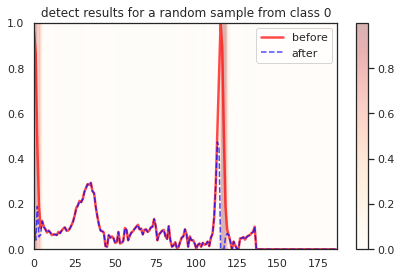

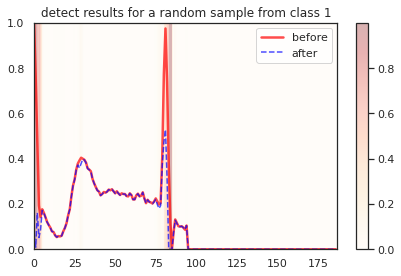

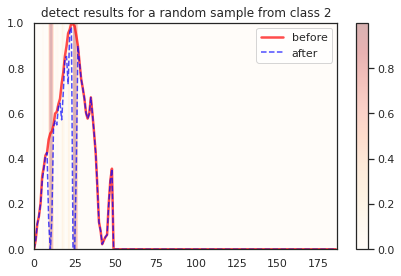

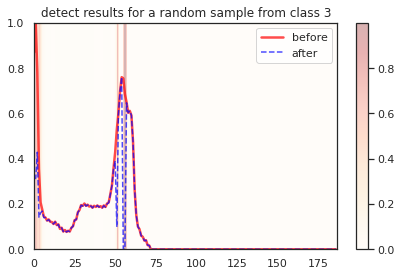

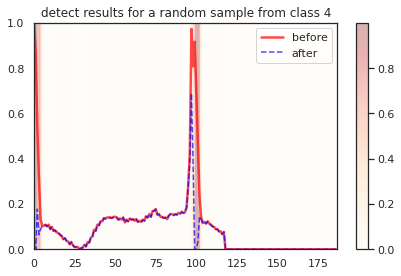

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style= 'white', palette=None)

timepoint = list(range(187))
X_demo = cue.X_demo
X_demo_detect = cue.detector.predict(X_demo)
X_demo_hl =  - (X_demo_detect - X_demo) / (X_demo + 1e-5)

for i in range(len(X_demo)):
    X_tmp, X_detect_tmp, X_hl_tmp = X_demo[i], X_demo_detect[i], X_demo_hl[i]
    plt.figure()
    plt.title('detect results for a random sample from class %s' %i)
    plt.imshow(X_hl_tmp[np.newaxis,:], cmap="OrRd", aspect='auto', alpha=0.3, 
                                        extent = (0, 187, 0, 1))
    plt.colorbar()
    plt.plot(timepoint, X_tmp, linewidth=2.5, alpha=.7, color='r', label='before')
    plt.plot(timepoint, X_detect_tmp, linewidth=1.5, alpha=.7, color='b', linestyle='--', label='after')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()